### BACKGROUND REMOVAL OF UNIMODAL & BIMODAL IMAGES USING OTSU ALGORITHM

In [1]:
import math
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import statistics
# packages I used for this assignment 

### NOTICE 
<ul>
<li>This works based on Otsu algorithm + Connected Component algorithm and all those give you background white. </li>
<li>This only works when your image is having a single important feature and in case of multiple features it gives you most priority image </li>
    <li>This only works when your image is having clear distinction between background and the feature that you want to extract</li>
    </ul>

In [2]:
def binarizegrayscaleimage(I,t):
    '''Given gray scale image I, threshold t this function binarize content or map all intensity levels from 0 to 255 to
    0 or 1 and returns corresponding binarized image'''
    J=np.zeros(I.shape)
#     copies image I into J
    J[I >= t] = 1 # transformed image for given threshold
    return J

In [3]:
def histogram_pmf(I):
    '''This function takes gray scale image I and return histogram PMF after computing it without plotting'''
    histogram=np.zeros(256)
#     creating array of histogram and initializing with zero
    for i in range(len(I)):
        for j in range(len(I[i])):
            histogram[I[i][j]]=histogram[I[i][j]]+1
            
    imgsize=len(I)*len(I[0])
#    Now we computed histogram representing all counts of intensisties
    return histogram/imgsize

In [4]:
 def linear_operation(P,L,I):
    '''Takes image I as input and returns P*I+L'''
    J=P*I+L
    J=np.round_(J)
#   rounds to nearest integer as we will quantize all possible intensities to 2^B levels where B=8 in grayscale image
    J[J>=256]=255
    J[J<=0]=0
    J=J.astype('int64')
    return J

def FSCS(I):
    '''Takes A(maximum of I), B(minimum of I), I(image) and K(maximum possible intenisty value)'''
    A=np.max(I)
    B=np.min(I)
    K=255
    if(A==B):
        return I
    P=(K-1)/(A-B)
    L=-1*B*(K-1)/(A-B)
    return linear_operation(P,L,I)

In [5]:
def removeminorblob(I,R):
    '''Takes Image I and Labelled array R and returns array that has only Major blob with I[i][j]=0 (black color)'''
    all_blobs_count=np.zeros(100000) #taking maximum number of blobs in image is 100000 and proceeding
    for i in range(len(R)):
        for j in range(len(R[i])):
            all_blobs_count[R[i][j]]+=1


    # Now all_blobs_count will have count of ith blob where i ranges from 0 to 99999
    max_index=0
    max_area=0
    for i in range(1,len(all_blobs_count)):
        if(all_blobs_count[i]>max_area):
            max_area=all_blobs_count[i]
            max_index=i

    for i in range(len(I)):
        for j in range(len(I[i])):
            if(I[i][j]==0 and R[i][j]!=max_index):
                I[i][j]=1

In [6]:
def connected_components_algo(I):
    '''Takes I as input and outputs labelled array which was labelled with respect to 4 connectivity'''
    
    R = np.zeros(I.shape,dtype='int')

    # Initialize the label counter
    k = 1

    # Iterate through the binary matrix
    for row in range(len(I)):
        for col in range(len(I[row])):
            if I[row][col] == 0 and R[row][col] == 0:
                # Use dfs to label the connected component
                stack = [(row, col)]
                while len(stack) > 0:
                    (i, j) = stack.pop()
                    R[i][j] = k
                    if i > 0 and I[i - 1][j] == 0 and R[i - 1][j]==0:
                        stack.append((i - 1, j))
                    if i < len(I) - 1 and I[i + 1][j] == 0 and R[i + 1][j]==0:
                        stack.append((i + 1, j))
                    if j > 0 and I[i][j - 1] == 0 and R[i][j - 1]==0:
                        stack.append((i, j - 1))
                    if j < len(I[0]) - 1 and I[i][j + 1] == 0 and R[i][j + 1]==0:
                        stack.append((i, j + 1))
                k=k+1
    
    return R

def removeblobs(Jb):
    R=connected_components_algo(Jb)
    Jb_copy=np.copy(Jb)
    outer_minor_blob_removal=removeminorblob(Jb_copy,R)

    T=np.copy(Jb_copy)

    T[Jb_copy==0]=1
    T[Jb_copy==1]=0
    # complementing the image T (copy of binarized version of APC image)

    R_comp=connected_components_algo(T)
    # to remove inner minor blobs
    removeminorblob(T,R_comp)

    Jb_copy[T==0]=1
    Jb_copy[T==1]=0
    
    return Jb_copy

In [7]:
def otsu(I):
    '''Takes gray scale image I and return threshold after applying ostu algorithm method B'''
    required_threshold=0
    weighted_interclass_variation=np.zeros(256)
    hist=histogram_pmf(I)
    weighted_interclass_variation_t=-1
    image_size=len(I)*len(I[0])
    P0=np.zeros(256)
    P0[0]=hist[0] #Initalizing P0 with 0
    mu0=np.zeros(256) #Initializing mu0 with 0
    mu1=np.zeros(256)
    mean_image=np.mean(I)
    mu1[0]=mean_image #initializing mu1[0] with mean of image I as every pixel is mapped to bit 1 for 0th iteration
    P1=np.zeros(256) 
    P1[0]=1 #Initializing P1 with 1 as P0=0=1-P1
    
    
    for intensity in range(1,256):
        P0[intensity]=P0[intensity-1]+hist[intensity]
        mu0[intensity]=0 if P0[intensity]<=0 else (mu0[intensity-1]*P0[intensity-1]+intensity*hist[intensity])/P0[intensity]
        mu1[intensity]=0 if 1-P0[intensity]<=0 else (mean_image-mu0[intensity]*P0[intensity])/(1-P0[intensity])
        weighted_interclass_variation[intensity]=P0[intensity]*(1-P0[intensity])*((mu0[intensity]-mu1[intensity])**2)
    
    for intensity in range(256):
        if(weighted_interclass_variation_t<=weighted_interclass_variation[intensity]):
            weighted_interclass_variation_t=weighted_interclass_variation[intensity]
            required_threshold=intensity
    return required_threshold 

In [8]:
 # for returing grayscale image 
def rgb2gray(rgb):
    '''Takes an color image with R,G,B three channels as input and then converts to grayscale image'''
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray=np.round_(gray)
    gray=gray.astype('int64')
    return gray

In [9]:
def displayImage(I):
    if(len(I.shape)<3):
        plt.imshow(I,cmap='gray')
    elif len(I.shape)==3:
        plt.imshow(I)
    else:
        print("Cannot display image. May be corrupted image")

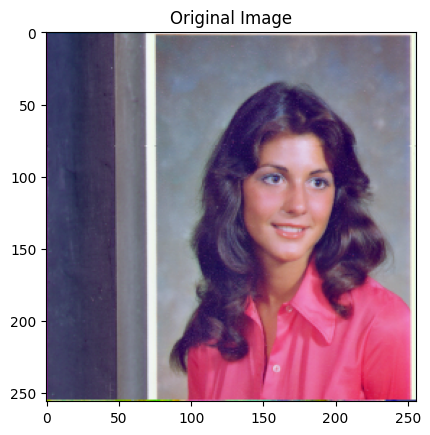

In [10]:
image_read=img.imread('7.1.01.tiff')
plt.title('Original Image')
displayImage(image_read)

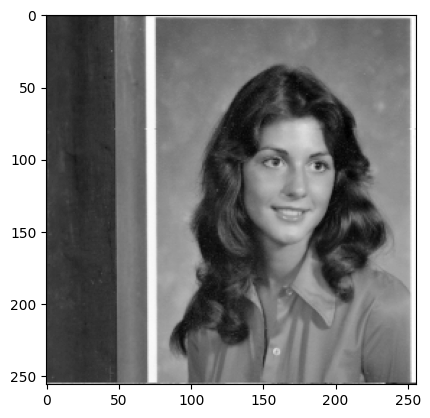

In [11]:
image_read_gray=image_read
if(len(image_read.shape)==3):
    image_read_gray=rgb2gray(image_read)
    
displayImage(image_read_gray)

In [12]:
image_read_gray=FSCS(image_read_gray)
threshold=otsu(image_read_gray)

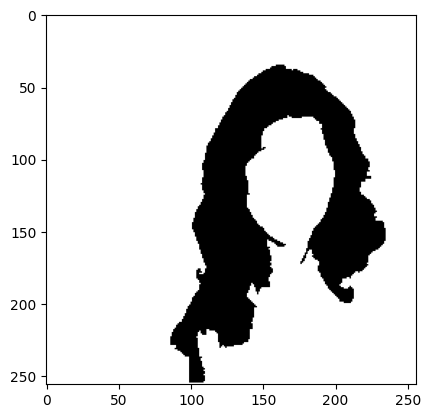

In [13]:
I=binarizegrayscaleimage(FSCS(image_read_gray),threshold)
I=removeblobs(I)
displayImage(I)

In [14]:
image_bg_removed=image_read
if(len(image_read.shape)<3):
    for i in range(len(image_read)):
        for j in range(len(image_read[i])):
            if(I[i][j]==1):
                image_bg_removed[i][j]=255
elif(len(image_read.shape)==3):
    for i in range(len(image_read)):
        for j in range(len(image_read[i])):
            for m in range(3):
                if(I[i][j]==1):
                    image_bg_removed[i][j][m]=255

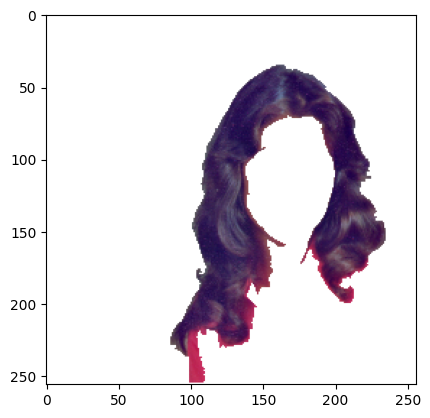

In [15]:
displayImage(image_bg_removed)